In [262]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 1. Synaptic current 

# (a) & (b)

In [263]:
# Params

pars_a_1 = {
    'tau_syn': 10 * 10**-3,
    'tau_m'  : 10 * 10**-3,
    'R_m'    : 1  * 10**7,
    'g_star' : 30 * 10**-9,
    'E_m'    : -80 * 10**-3,
    'E_exc'  : 0 * 10**-3,
    'E_inh'  : 0 * 10**-3,
    'E_syn'  : 0 * 10**-3,
    'g_exc'  : 0 * 10**-9,
    'g_inh'  : 0 * 10**-9,
    'I_e'    : 0 * 10**-9,
    'thr'    : -54 * 10**-3 
}


pars_a_2 = {
    'tau_syn': 10 * 10**-3,
    'tau_m'  : 10 * 10**-3,
    'R_m'    : 1  * 10**7,
    'g_star' : 30 * 10**-9,
    'E_m'    : -80 * 10**-3,
    'E_exc'  : 0 * 10**-3,
    'E_inh'  : 0 * 10**-3,
    'E_syn'  : -100 * 10**-3,
    'g_exc'  : 0 * 10**-9,
    'g_inh'  : 0 * 10**-9,
    'I_e'    : 0 * 10**-9,
    'thr'    : -54 * 10**-3 
}

pars_b = {
    'tau_syn': 10 * 10**-3,
    'tau_m'  : 10 * 10**-3,
    'R_m'    : 1  * 10**7,
    'g_star' : 30 * 10**-9,
    'E_m'    : -80 * 10**-3,
    'E_exc'  : 0 * 10**-3,
    'E_inh'  : -100 * 10**-3,
    'E_syn'  : 0 * 10**-3,
    'g_exc'  : 50 * 10**-9,
    'g_inh'  : 200 * 10**-9,
    'I_e'    : 0 * 10**-9,
    'thr'    : -54 * 10**-3   
}

ics = (-80*10**-3, 0, 0, 0)

In [264]:
def euler_synaptic_if(tmax, dt, pre_spike_times, ics, pars, reset=False):
    
    tau_syn = pars['tau_syn']
    tau_m   = pars['tau_m']
    R_m     = pars['R_m']
    g_star  = pars['g_star']
    E_m     = pars['E_m']
    E_exc   = pars['E_exc']
    E_inh   = pars['E_inh']
    E_syn   = pars['E_syn']
    g_exc   = pars['g_exc']
    g_inh   = pars['g_inh']
    I_e     = pars['I_e']
    thr     = pars['thr']

    V, x, g, I_syn = ics
    
    ts = np.arange(0, tmax, dt)
    Vs = np.array([])
    gs = np.array([])
    xs = np.array([])
    I_syns = np.array([])
    spiketimes = np.array([])
    
    for t in ts:

        if any(abs(t - ts0) < dt/2 for ts0 in pre_spike_times):
            x += g_star
        
        dVdt = ( -V + E_m - R_m*I_syn + R_m*I_e ) / tau_m
        dxdt = -x / tau_syn
        dgdt = (x - g) / tau_syn
        I_syn = g*(V - E_syn) + g_exc*(V - E_exc) + g_inh*(V - E_inh)
        
        V = V + dt*dVdt
        x = x + dt*dxdt
        g = g + dt*dgdt

        if reset == True and V >= thr:
            V = E_m
            spiketimes = np.append(spiketimes, t)
        
        Vs = np.append(Vs, V)
        gs = np.append(gs, g)
        xs = np.append(xs, x)
        I_syns = np.append(I_syns, I_syn)

    return {
        'ts' : ts / 10**-3, 
        'V_t' : Vs / 10**-3, 
        'g_syn_t' : gs / 10**-9, 
        'x_t' : xs, 
        'I_syn_t' : I_syns / 10**-9,
        'spiketimes' : spiketimes / 10**-3
        }


In [265]:
sol = []

for pars in [pars_a_1, pars_a_2, pars_b]:
    sol.append(euler_synaptic_if(tmax=0.2, dt=1e-4, pre_spike_times=[0.04], ics=ics, pars=pars))

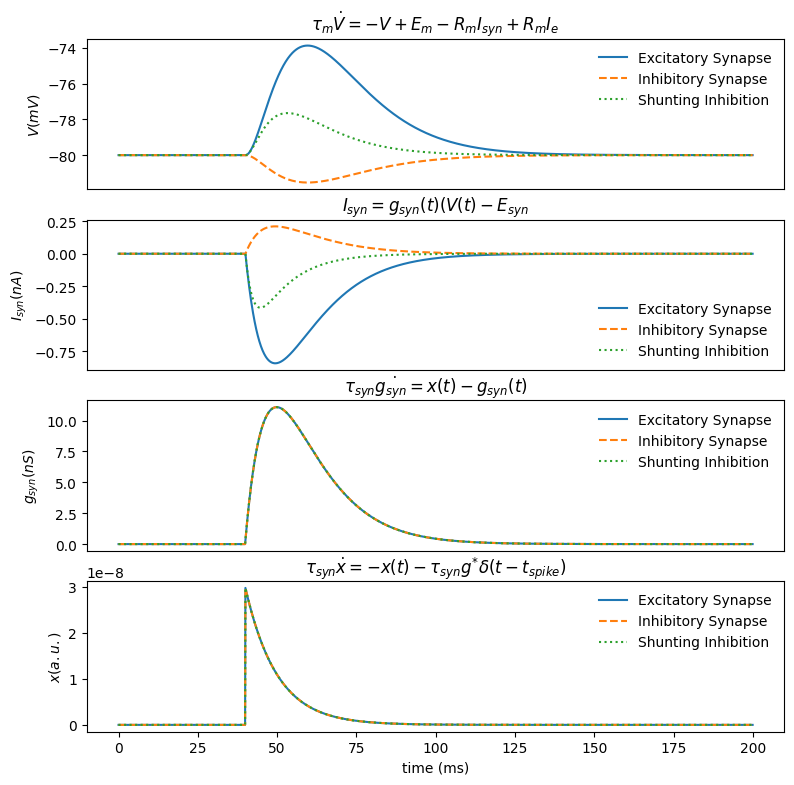

In [266]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(9, 9))


ax1.plot(sol[0]["ts"], sol[0]['V_t'], label="Excitatory Synapse")
ax1.plot(sol[1]["ts"], sol[1]['V_t'], linestyle="--", label="Inhibitory Synapse")
ax1.plot(sol[2]["ts"], sol[2]['V_t'], linestyle=":", label="Shunting Inhibition")

ax2.plot(sol[0]["ts"], sol[0]['I_syn_t'], label="Excitatory Synapse")
ax2.plot(sol[1]["ts"], sol[1]['I_syn_t'], linestyle="--", label="Inhibitory Synapse")
ax2.plot(sol[2]["ts"], sol[2]['I_syn_t'], linestyle=":", label="Shunting Inhibition")

ax3.plot(sol[0]["ts"], sol[0]['g_syn_t'], label="Excitatory Synapse")
ax3.plot(sol[1]["ts"], sol[1]['g_syn_t'], linestyle="--", label="Inhibitory Synapse")
ax3.plot(sol[2]["ts"], sol[2]['g_syn_t'], linestyle=":", label="Shunting Inhibition")

ax4.plot(sol[0]["ts"], sol[0]['x_t'], label="Excitatory Synapse")
ax4.plot(sol[1]["ts"], sol[1]['x_t'], linestyle="--", label="Inhibitory Synapse")
ax4.plot(sol[2]["ts"], sol[2]['x_t'], linestyle=":", label="Shunting Inhibition")

for ax, title, ylabel in zip(
    [ax1, ax2, ax3, ax4],
    [
        "$\\tau_{m}\\dot{V} = -V + E_{m} - R_{m}I_{syn} + R_{m}I_{e}$",
        "$I_{syn} = g_{syn}(t)(V(t) - E_{syn}$",
        "$\\tau_{syn} \\dot{g_{syn}} = x(t) - g_{syn}(t)$",
        "$\\tau_{syn} \\dot{x} = -x(t) - \\tau_{syn}g^{*}\\delta(t-t_{spike})$"
    ],
    ["$V (mV)$", "$I_{syn} (nA)$", "$g_{syn} (nS)$", "$x (a.u.)$"]):

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend(frameon=False, loc='best')

    if ax != ax4:
        ax.set_xticks([])
    else:
        ax.set_xlabel("time (ms)")

plt.show()

# Explaining the differences

a.) The voltage deflection caused by the inhibtory synapse is much smaller than the one caused by the excitatory synapse due to the differences between the resting membrane potential and the respective reversal potentials (80 mV for the exc. synapse vs. 20 mV for the inh. synapse).

b.) Shunting inhibition introduces additional channels into the membrane, thereby increasing its effective leakiness and in turn decreases the input resistance and the membrane time constant. This leads to decreased integration of the synaptic input current and ultimately results in a smaller voltage defelction.

# 2. Integrate-and-fire neuron

# (a), (b) & (c)

In [267]:
def get_fr_ISI(spiketimes):
    spiketimes *= 10**-3
    if len(spiketimes) > 1:
        mean_isi = np.mean([spiketimes[i+1] - spiketimes[i] for i in range(len(spiketimes) - 1)])
        fr = 1 / mean_isi
    else:
        fr = 0
    return fr

In [268]:
def get_fr_num(spiketimes, simtime):
    if len(spiketimes) > 1:
        fr = len(spiketimes) / simtime
    else:
        fr = 0
    return fr

In [269]:
def analytical_fr(pars):

    tau_syn = pars['tau_syn']
    tau_m   = pars['tau_m']
    R_m     = pars['R_m']
    g_star  = pars['g_star']
    E_m     = pars['E_m']
    E_exc   = pars['E_exc']
    E_inh   = pars['E_inh']
    E_syn   = pars['E_syn']
    g_exc   = pars['g_exc']
    g_inh   = pars['g_inh']
    I_e     = pars['I_e']
    thr     = pars['thr']
    V_reset = pars['E_m']
    
    fr = (tau_m * np.log( (R_m*I_e + E_m - V_reset) / (R_m*I_e + E_m - thr) )) ** -1

    return fr

In [270]:
pars_2_b = {
    'tau_syn': 10 * 10**-3,
    'tau_m'  : 10 * 10**-3,
    'R_m'    : 1  * 10**7,
    'g_star' : 30 * 10**-9,
    'E_m'    : -80 * 10**-3,
    'E_exc'  : 0 * 10**-3,
    'E_inh'  : -100 * 10**-3,
    'E_syn'  : 0 * 10**-3,
    'g_exc'  : 0 * 10**-9,
    'g_inh'  : 0 * 10**-9,
    'I_e'    : 3 * 10**-9,
    'thr'    : -54 * 10**-3   
}

In [277]:
input_stimuli = np.linspace(0, 5, 250) 

firing_rates_100_a = np.empty(len(input_stimuli))
firing_rates_500_a = np.empty(len(input_stimuli))

firing_rates_100_b = np.empty(len(input_stimuli))
firing_rates_500_b = np.empty(len(input_stimuli))

analytical_frs =  np.empty(len(input_stimuli))

for k, I_ext in enumerate(input_stimuli):

    initial_V = np.random.choice(np.arange(-85, -75, 0.1) * 10**-3)
    ics = (initial_V, 0, 0, 0)

    pars = pars_2_b.copy()
    pars['I_e'] = I_ext * 10**-9

    sol_1 = euler_synaptic_if(tmax=0.1, dt=1e-4, pre_spike_times=[], pars=pars, ics=ics, reset=True)
    firing_rates_100_a[k] = get_fr_ISI(sol_1['spiketimes'])
    firing_rates_100_b[k] = get_fr_num(sol_1['spiketimes'], np.max(sol_1['ts']) * 10**-3)

    sol_2 = euler_synaptic_if(tmax=0.5, dt=1e-4, pre_spike_times=[], pars=pars, ics=ics, reset=True)
    firing_rates_500_a[k] = get_fr_ISI(sol_2['spiketimes'])
    firing_rates_500_b[k] = get_fr_num(sol_2['spiketimes'], np.max(sol_2['ts']) * 10**-3)

    analytical_frs[k] = analytical_fr(pars)

/tmp/ipykernel_134480/1782649956.py:17: RuntimeWarning: divide by zero encountered in log
  fr = (tau_m * np.log( (R_m*I_e + E_m - V_reset) / (R_m*I_e + E_m - thr) )) ** -1
/tmp/ipykernel_134480/1782649956.py:17: RuntimeWarning: invalid value encountered in log
  fr = (tau_m * np.log( (R_m*I_e + E_m - V_reset) / (R_m*I_e + E_m - thr) )) ** -1


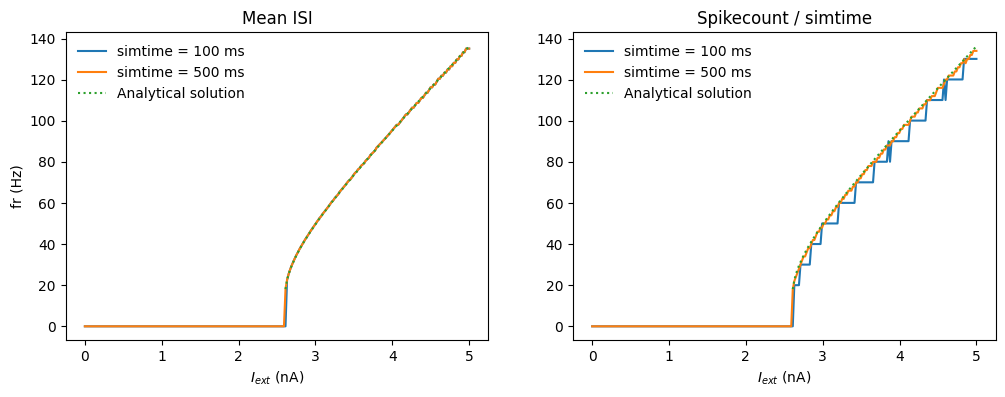

In [280]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(input_stimuli, firing_rates_100_a, label="simtime = 100 ms")
ax1.plot(input_stimuli, firing_rates_500_a, label="simtime = 500 ms")
ax1.plot(input_stimuli, analytical_frs, linestyle=":", label="Analytical solution")
ax1.set_title('Mean ISI')
ax1.set_ylabel('fr (Hz)')
ax1.set_xlabel('$I_{ext}$ (nA)')
ax1.legend(frameon=False)

ax2.plot(input_stimuli, firing_rates_100_b, label="simtime = 100 ms")
ax2.plot(input_stimuli, firing_rates_500_b, label="simtime = 500 ms")
ax2.plot(input_stimuli, analytical_frs, linestyle=":", label="Analytical solution")
ax2.set_title('Spikecount / simtime')
ax2.set_xlabel('$I_{ext}$ (nA)')
ax2.legend(frameon=False)

plt.show()